In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

emg_data = loadmat('../../mocap_EMG_EEG_data/AB_UH_07T09emg.mat')

In [3]:
# 左腿與右腿
len(emg_data['emg'][0,0])

2

In [4]:
# 每條腿有 6個 EMG 電極
emg_data['emg'][0,0][0].shape

(6, 152666)

In [5]:
sampling_rate = 1000
left_emg = emg_data['emg'][0,0][0]
t = np.arange(left_emg.shape[1]) / sampling_rate

In [6]:
t.shape, left_emg.shape

((152666,), (6, 152666))

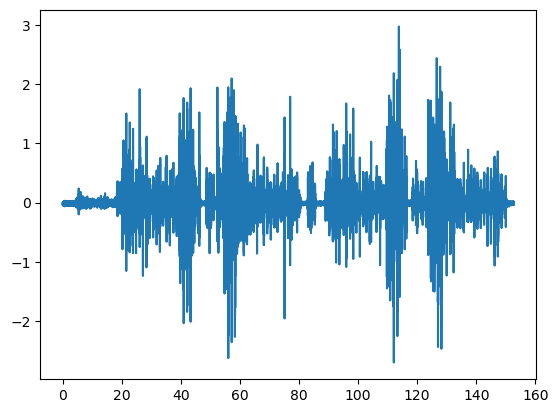

In [7]:
# 假設先處理第3個電極
channel = 3
plt.plot(t, left_emg[channel, ...])

In [8]:
plt.rcParams["figure.figsize"] = (20,6)

(20.0, 30.0)

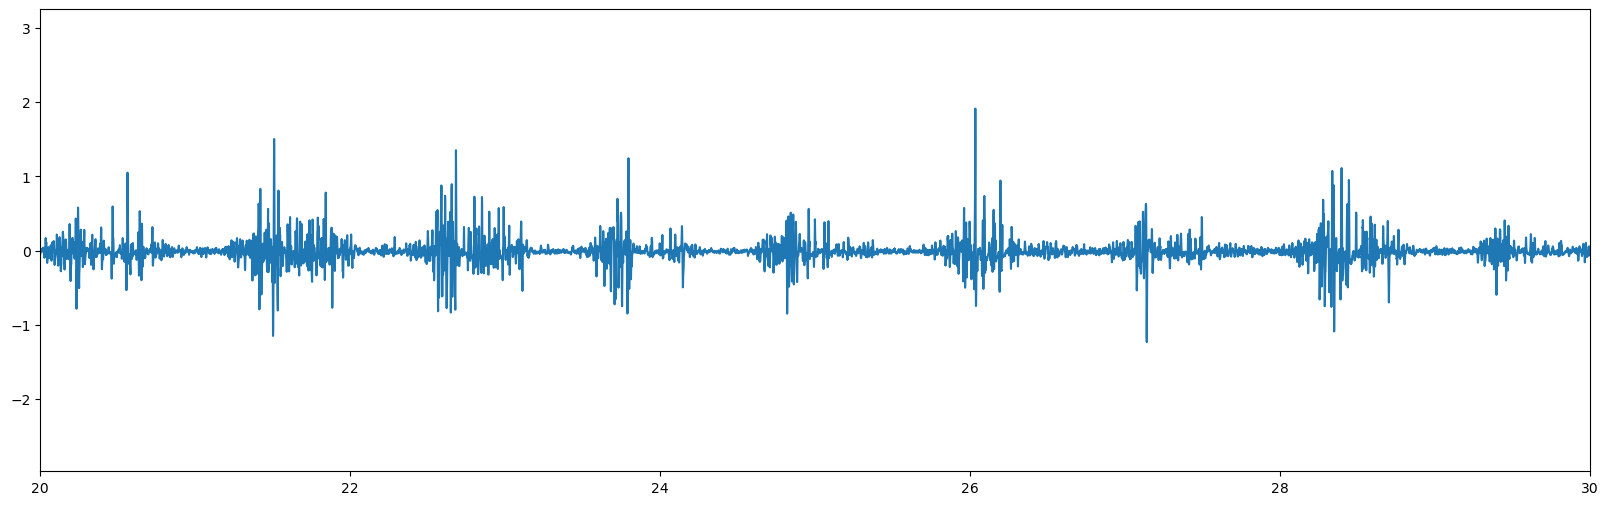

In [9]:
# 假設先處理第3個電極，只畫出 20~30 sec 的部分
plt.plot(t, left_emg[channel, ...])
plt.xlim(20, 30)

In [10]:
from scipy.fft import fft, fftfreq, ifft

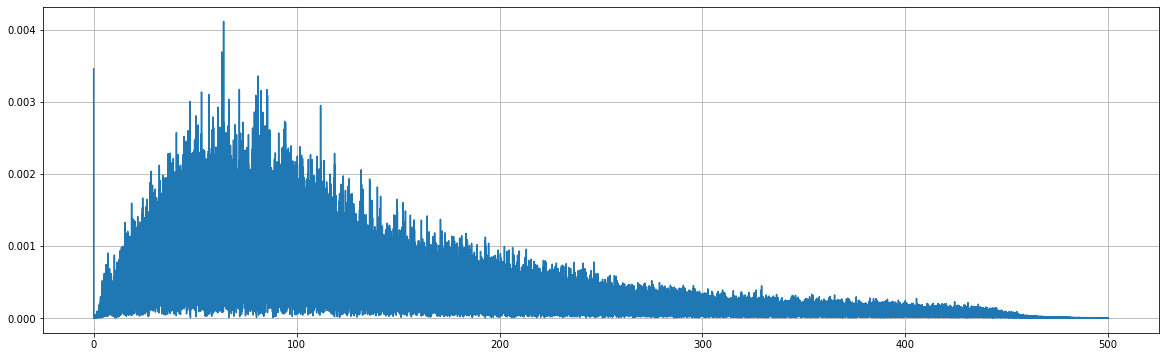

In [16]:
# Number of sample points
N = len(left_emg[0,...])
# sample spacing
T = 1.0 / sampling_rate
x = np.linspace(0.0, N*T, N, endpoint=False)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = left_emg[0, ...]
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

In [17]:
from scipy.signal import iirnotch, butter, filtfilt
from collections import deque

class BandFilter:
    def __init__(self, order=4, fc_bp=[20, 480], freq=1000):
        nyq = 0.5 * freq
        low = fc_bp[0] / nyq
        high = fc_bp[1] / nyq
        self.b, self.a = butter(order, (low, high), btype = 'bandpass', output='ba')
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x
    
class LowPassFilter:
    def __init__(self, order=2, fc_bp=4, freq=1000):
        nyq = 0.5 * freq
        low = fc_bp / nyq
        self.b, self.a = butter(order, low, btype = 'lowpass', output='ba')
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x

class HighPassFilter:
    def __init__(self, order=2, fc_bp=30, freq=1000):
        nyq = 0.5 * freq
        high = fc_bp / nyq
        self.b, self.a = butter(order, high, btype = 'highpass', output='ba')
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x

class NotchFilter:
    def __init__(self, f0=60, freq=1000):
        f0 = f0  # Frequency to be removed from signal (Hz)
        Q = 30.0  # Quality factor
        self.b, self.a = iirnotch(f0, Q, freq)
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x

In [18]:
h_filter = HighPassFilter(order=4, fc_bp=30)
l_filter = LowPassFilter(order=4, fc_bp=4)
n_filter = NotchFilter(f0=60)

In [19]:
filted_emg = h_filter.filtfilt(left_emg[channel,...])

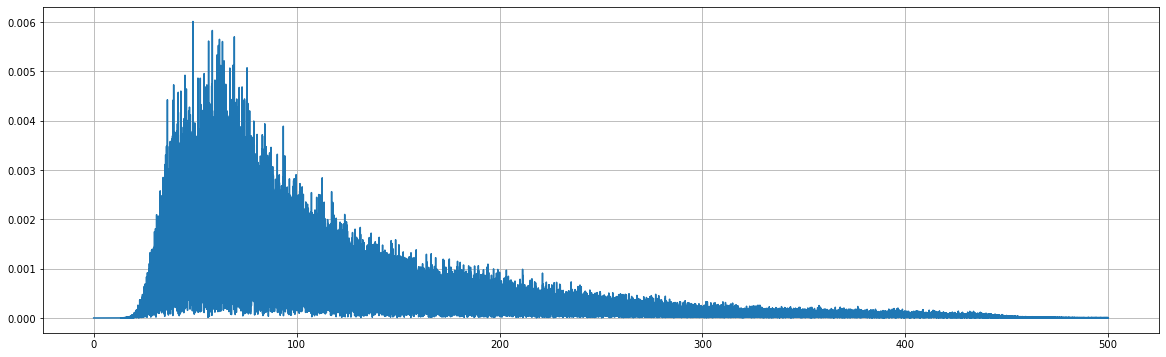

In [20]:
# 注意到經過 high pass 之後只留下 30 Hz 以上 (X軸)
yf = fft(filted_emg)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

In [21]:
# 用 notch 濾掉 60Hz 
filted_emg = n_filter.filtfilt(filted_emg)

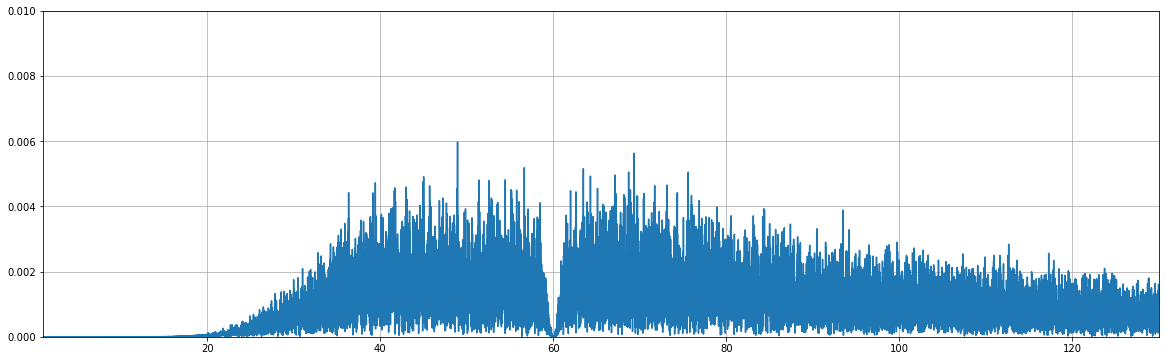

In [22]:
# 注意到經過 notch filter 之後 60 Hz 被消除 (X軸)
yf = fft(filted_emg)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(1, 130)
plt.ylim(0, 0.01)
plt.grid()

In [23]:
# rectification 就是取 abs 而已
rect_emg = np.abs(filted_emg)

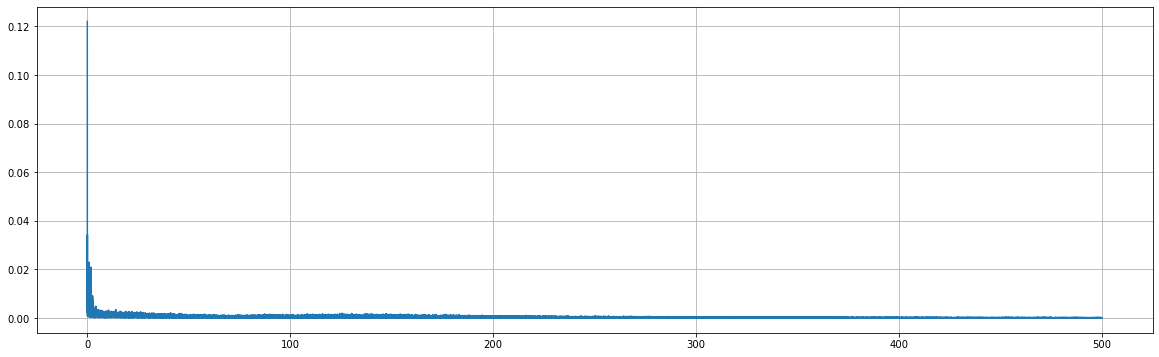

In [24]:
yf = fft(rect_emg)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

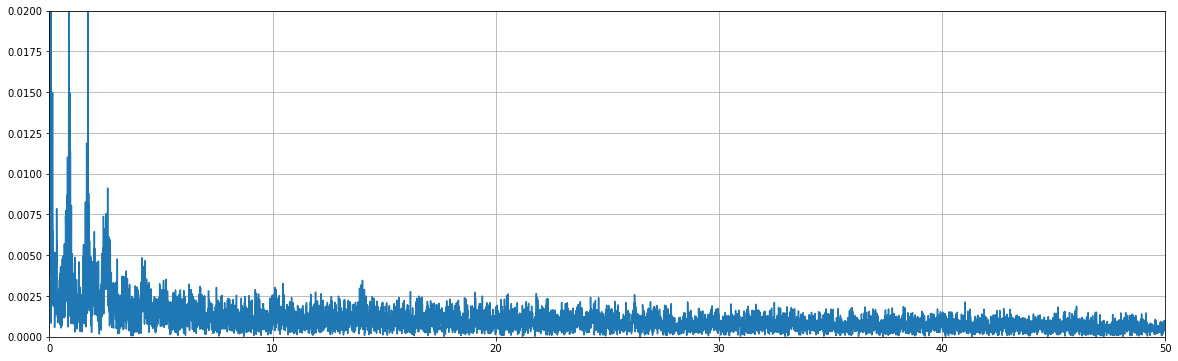

In [25]:
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 50)
plt.ylim(0, 0.02)
plt.grid()

In [26]:
# 低通濾波，只保留 4Hz 以下
envelope = l_filter.filtfilt(rect_emg)

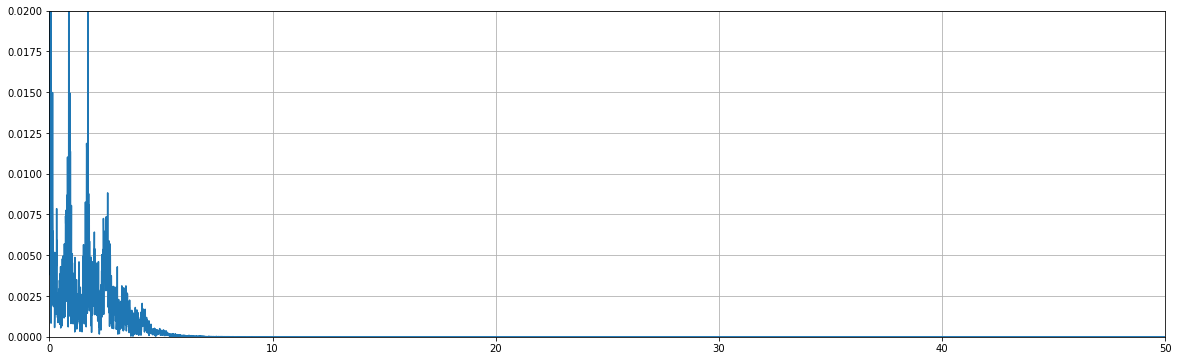

In [27]:
yf = fft(envelope)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 50)
plt.ylim(0, 0.02)
plt.grid()

In [28]:
t.shape, envelope.shape

((152666,), (152666,))

(20.0, 30.0)

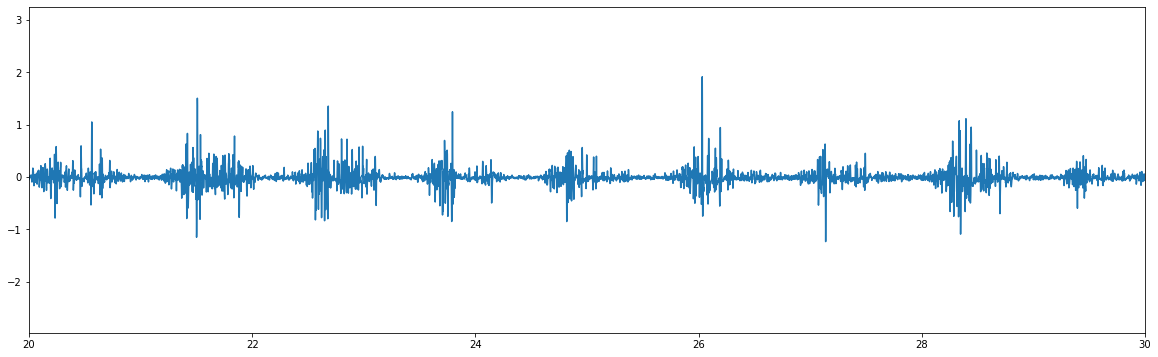

In [29]:
plt.plot(t, left_emg[channel, ...])
plt.xlim(20, 30)
# plt.ylim(-2, 2)

(20.0, 30.0)

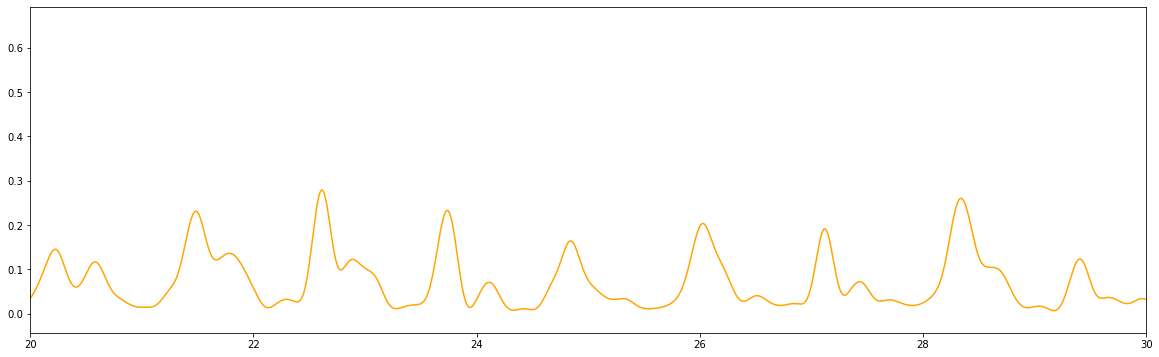

In [30]:
plt.plot(t, envelope, 'orange')
plt.xlim(20, 30)
# plt.ylim(0, 0.3)

(-0.5, 0.5)

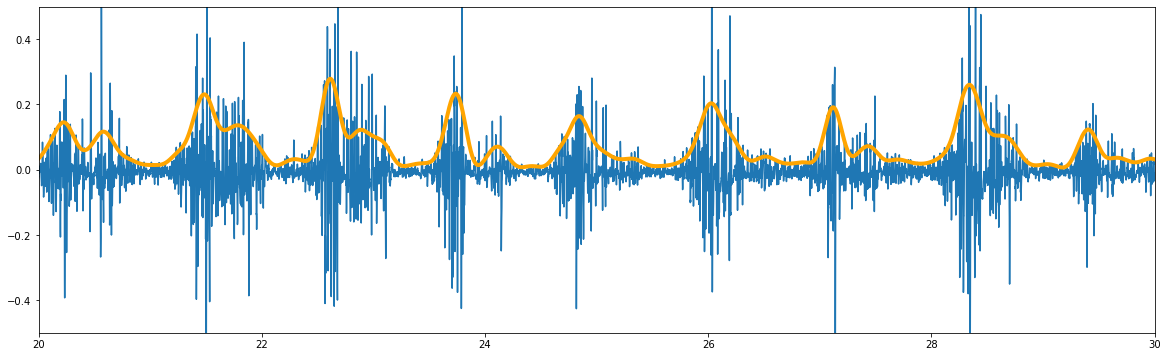

In [31]:
plt.plot(t, 0.5 * left_emg[channel, ...])
plt.plot(t, envelope, 'orange', linewidth=4)
plt.xlim(20, 30)
plt.ylim(-0.5, 0.5)